In [3]:
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow as tf
import tensorflow_datasets as tfds
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.model_selection import GroupShuffleSplit

In [4]:
os.chdir('/scratch4/en520-lmorove1/en520-ikarhul1/melanoma/classification')

In [5]:
df = pd.read_csv('../data/HAM10000/HAM10000_metadata.csv')
df['image_path'] = df['image_id'] + '.jpg'
df['label'] = (df['dx']=='mel').astype(int)
df = df.drop(columns=['image_id','dx','dx_type','age','sex','localization'])

In [6]:
df

,lesion_id,image_path,label
0,HAM_0000118,ISIC_0027419.jpg,0
1,HAM_0000118,ISIC_0025030.jpg,0
2,HAM_0002730,ISIC_0026769.jpg,0
3,HAM_0002730,ISIC_0025661.jpg,0
4,HAM_0001466,ISIC_0031633.jpg,0
...,...,...,...
10010,HAM_0002867,ISIC_0033084.jpg,0
10011,HAM_0002867,ISIC_0033550.jpg,0
10012,HAM_0002867,ISIC_0033536.jpg,0
10013,HAM_0000239,ISIC_0032854.jpg,0


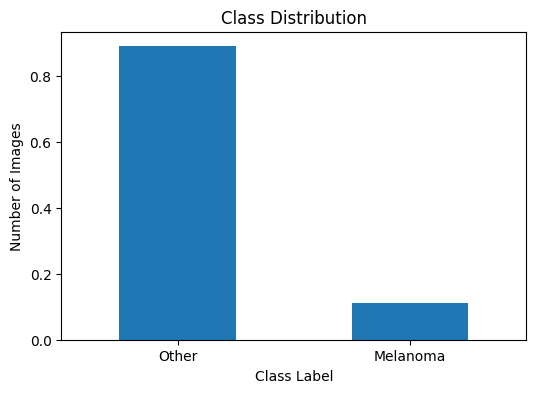

melanoma: 11.11 %
other: 88.89 %


In [7]:
proportions = df['label'].value_counts().sort_index()/len(df)
plt.figure(figsize=(6,4))
proportions.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0,1], labels=['Other', 'Melanoma'], rotation=0)
plt.show()
proportions = proportions*100
print(f'melanoma: {proportions[1]:.4} %')
print(f'other: {proportions[0]:.4} %')

In [8]:
splitter1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trainval_idx, test_idx = next(splitter1.split(df, groups=df['lesion_id']))
trainval_df = df.iloc[trainval_idx]
test_df = df.iloc[test_idx]

splitter2 = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_idx, val_idx = next(splitter2.split(trainval_df, groups=trainval_df['lesion_id']))
train_df = trainval_df.iloc[train_idx]
val_df = trainval_df.iloc[val_idx]

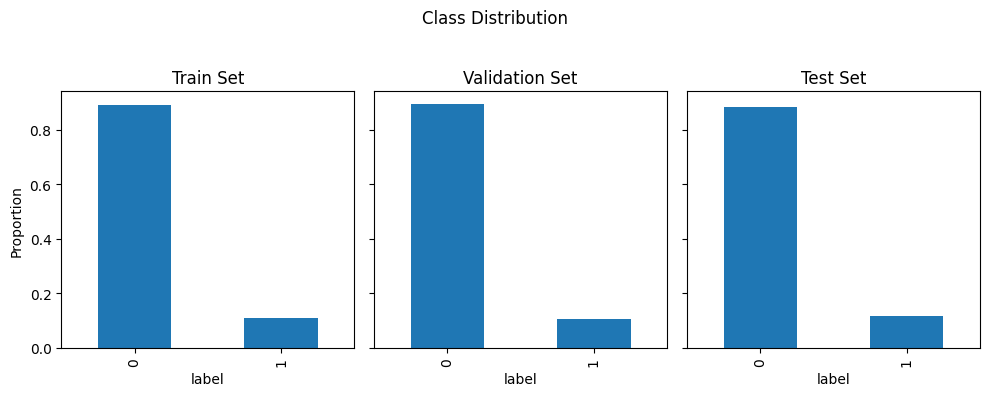

In [9]:
train_proportions = train_df['label'].value_counts().sort_index()/len(train_df)
val_proportions = val_df['label'].value_counts().sort_index()/len(val_df)
test_proportions = test_df['label'].value_counts().sort_index()/len(test_df)
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
train_proportions.plot.bar(ax=axes[0])
axes[0].set_title('Train Set')
axes[0].set_ylabel('Proportion')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
val_proportions.plot.bar(ax=axes[1])
axes[1].set_title('Validation Set')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
test_proportions.plot.bar(ax=axes[2])
axes[2].set_title('Test Set')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)
fig.suptitle('Class Distribution')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [10]:
class MelanomaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['image_path'])
        image = read_image(img_path).float()/255.0
        label = torch.tensor(self.df.iloc[idx]['label'], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [11]:
transforms = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = MelanomaDataset(train_df, '../data/HAM10000/images', transforms)
test_dataset = MelanomaDataset(test_df, '../data/HAM10000/images', transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cpu')

In [14]:
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model = model.to(device)

In [13]:
num_pos = (train_df['label'] == 1).sum()
num_neg = (train_df['label'] == 0).sum()
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optim = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses = []

for epoch in range(epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.unsqueeze(1).float().to(device)
        pred = model(data)
        loss = criterion(pred, targets)

        optim.zero_grad()
        loss.backward()
        optim.step()

    losses.append(loss.item())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for data, targets in test_loader:  
            outputs = model(data)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    try:
        auc = roc_auc_score(all_targets, all_probs)
    except:
        auc = 0.0

    cm = confusion_matrix(all_targets, all_preds)
    
    return {'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc,
            'confusion_matrix': cm,
            'predictions': all_preds,
            'probabilities': all_probs,
            'targets': all_targets}

In [ ]:
results = evaluate_model(model, test_loader)

print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1 Score: {results['f1_score']:.4f}")
print(f"AUC: {results['auc']:.4f}")

Accuracy: 0.9070
Precision: 0.9231
Recall: 0.8880
F1 Score: 0.9052
AUC: 0.9717
